In [122]:
from ViolaJones import ViolaJones
import pickle
import numpy as np
import time
import matplotlib.pyplot as plt
from util import *
import skimage.io as io
from skimage.color import rgb2gray,rgb2hsv
import cv2
import commonfunctions as cf
from haar_utils import *

In [123]:
with open("Datasets/faces_cropped.pkl", 'rb') as f:
    data = pickle.load(f)
#print(len(data))
with open("Datasets/non-faces.pkl", 'rb') as f:
    data += pickle.load(f)
#print(len(data))
start_pos = 0
end_pos = 2500
start_neg = 5000
end_neg = 5080
train_data = data[start_pos:end_pos] + data[start_neg:end_neg]
images = []
labels =[]
for tup in train_data:
    images.append(tup[0])
    labels.append(tup[1])

In [124]:
# featurespath = "_" + str(start_pos) + "_" + str(end_pos) + "_" + str(start_neg) + "_" + str(end_neg)
# clf = ViolaJones(layers = [40], featurespath = "_" + str(start_pos) + "_" + str(end_pos) + "_" + str(start_neg) + "_" + str(end_neg))

# clf.train(images, np.array(labels))  # X_f (optional, to speed-up training)
# print("Training finished!")

# # Save weights
# print("\nSaving weights...")
# clf.save("cvj_weights_data_set_2" + featurespath + clf.layers)
# print("Weights saved!")

In [125]:
def evaluate(clf, X, y):
    metrics = {}
    true_positive, true_negative = 0, 0  # Correct
    false_positive, false_negative = 0, 0  # Incorrect
    for i in range(len(y)):
        prediction = clf.classify(X[i])
        if prediction == y[i]:  # Correct
            if prediction == 1:  # Face
                true_positive += 1
            else:  # No-face
                true_negative += 1
        else:  # Incorrect

            if prediction == 1:  # Face
                false_positive += 1
            else:  # No-face
                false_negative += 1

    metrics['true_positive'] = true_positive
    metrics['true_negative'] = true_negative
    metrics['false_positive'] = false_positive
    metrics['false_negative'] = false_negative

    metrics['accuracy'] = (true_positive + true_negative)/(true_positive+false_negative+true_negative+false_positive)
    metrics['precision'] = true_positive / (true_positive+false_positive)
    metrics['recall'] = true_positive / (true_positive+false_negative)  
    metrics['specifity'] = true_negative/(true_negative+false_positive)
    metrics['f1'] = (2.0 * metrics['precision'] * metrics['recall']) / (metrics['precision'] + metrics['recall'])

    return metrics


In [126]:
def test(clf, name="test"):
    # Load test set
    print("\nLoading {}...".format(name))
    with open("Datasets/test_faces_cropped.pkl", 'rb') as f:
        test = pickle.load(f)
    with open("Datasets/non-faces.pkl", 'rb') as f:
        test2 = pickle.load(f)
    #print(len(test))
    #print(len(test2))
    test = test + test2[3000:]
#     test = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)
#     test = [(cv2.resize(test , (19,19)) , 1)]
#     io.imshow(test[0][0])
    np.random.shuffle(test)
    images_test = []
    labels_test =[]
    for tup in test:
        images_test.append(tup[0])
        labels_test.append(tup[1])
    # Evaluate
    print("\nEvaluating...")
    metrics = evaluate(clf, images_test, np.array(labels_test))

    print("Metrics: [{}]".format(name))
    counter = 0
    for k, v in metrics.items():
        counter += 1
        if counter <= 4:
            print("\t- {}: {:,}".format(k, v))
        else:
            print("\t- {}: {:.3f}".format(k, v))

In [127]:
test(ViolaJones.load("cvj_weights_data_set_2_0_3000_5000_53001_40.pkl"))


Loading test...

Evaluating...
Metrics: [test]
	- true_positive: 6,686
	- true_negative: 4,227
	- false_positive: 38
	- false_negative: 375
	- accuracy: 0.964
	- precision: 0.994
	- recall: 0.947
	- specifity: 0.991
	- f1: 0.970


## Testing on some images

In [128]:
def gamma(values: np.ndarray, coeff: float=2.2) -> np.ndarray:
    return values**(1./coeff)

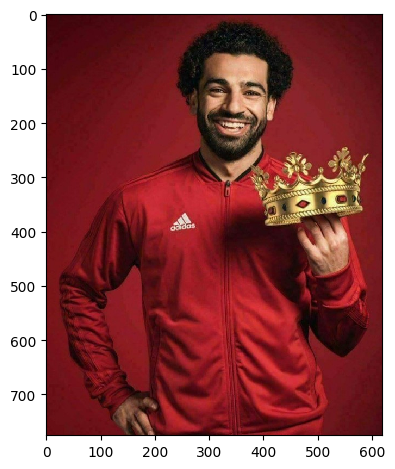

In [141]:
## reading the image and prprocess it
scientists= io.imread("./images/mosalah3.jpg")
io.imshow(scientists)

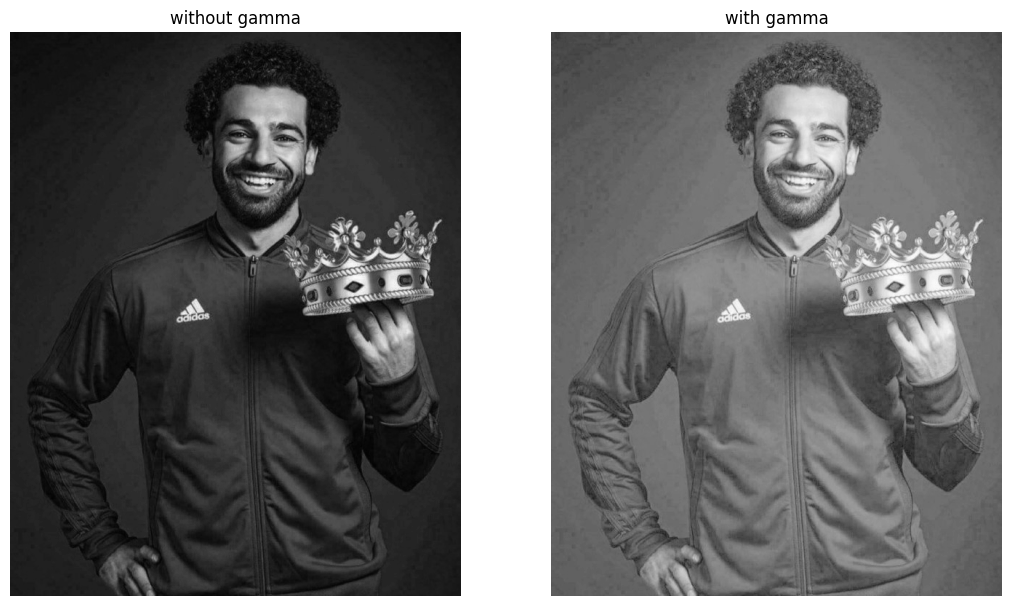

In [142]:
scientists_greyscale = cv2.cvtColor(scientists, cv2.COLOR_BGR2GRAY) /255
scientists_greyscale_enhanced = (gamma(scientists_greyscale) *255).astype(np.uint8)
cf.show_images([scientists_greyscale,scientists_greyscale_enhanced], ["without gamma", "with gamma"])

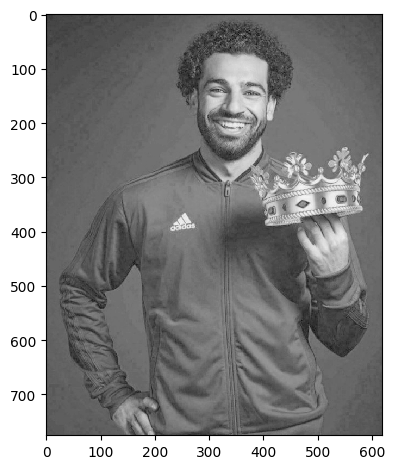

In [143]:
import imutils
## according to paper, image should be resized to (384, 288)
## using imutils is to maintain its aspect ratio
# scaled_width = 80
# final_image = imutils.resize(scientists_greyscale_enhanced , width=scaled_width)
# scale_h_factor = scientists.shape[1] / final_image.shape[1] 
# scale_w_factor = scientists.shape[0] / final_image.shape[0] 
final_image = scientists_greyscale_enhanced
io.imshow(final_image)

In [144]:
from haar_utils import *
window_size=19
rows, cols = final_image.shape
half_window = window_size // 2
# loading the viola-jones objectclfViolaJones.load("cvj_weights_data_set_2_0_2000_4000_5600_1_10_allftres.pkl")
clf_test=ViolaJones.load("cvj_weights_data_set_2_0_3000_5000_53001_40.pkl")
clf_test.clfs

In [145]:

def get_faces_in_multiple_scales(original_image, clf, shift=1):
    all_faces = []
    scale_w_factor = original_image.shape[0] / 19
    scale_h_factor = original_image.shape[1] / 19
    width = round(19 * scale_w_factor)
    height = round(19 * scale_h_factor) 
    while(width > 19 and height > 19):
        # print(scale_factor, width)
        new_image = imutils.resize(original_image , width=width)
        face_positions = get_best_faces_in_scale(half_window, new_image.shape[0], new_image.shape[1], new_image, clf, original_image.shape[0] / new_image.shape[0], original_image.shape[1] / new_image.shape[1], int(shift + shift * (max(scale_h_factor, scale_w_factor) // 10)))
        # print(f"Found {len(face_positions)} faces.")
        all_faces += (face_positions)
        scale_w_factor /= 1.1
        width = round(19 * scale_w_factor)
        scale_h_factor /= 1.1
        height = round(19 * scale_h_factor) 
    return all_faces
def get_best_faces_in_scale(half_window,rows,cols,final_image,clf_test, scale_w_factor, scale_h_factor, shift=1):
    # print(final_image.shape, scale_w_factor, scale_h_factor, half_window, shift)
    face_positions=[]
    for row in range(half_window + 1, rows - half_window,shift):
        for col in range(half_window + 1, cols - half_window,shift):
            # walking through the image with our window size
            if(row+half_window<=final_image.shape[0] and col+half_window+1<=final_image.shape[1]
              and row-half_window-1>=0 and col-half_window-1>=0):
                window = final_image[row-half_window-1:row+half_window+1, col-half_window-1:col+half_window+1]
            else:
                continue

            probably_face = clf_test.classify(window)
            if probably_face < .5:
                continue
            # print((row * scale_factor, col * scale_factor, 19 * scale_factor))
            face_positions.append((round(row * scale_w_factor), round(col * scale_h_factor), round(half_window * scale_w_factor), round(half_window * scale_h_factor)))
    return face_positions
all_possible_faces = get_faces_in_multiple_scales(final_image, clf_test, 4)
#print(all_possible_faces)

Found 4 faces.
Found 1 faces.
Found 4 faces.
Found 3 faces.
Found 3 faces.
Found 8 faces.
Found 5 faces.
Found 3 faces.
Found 8 faces.
Found 4 faces.
Found 4 faces.
Found 3 faces.
Found 8 faces.
Found 3 faces.
Found 3 faces.
Found 7 faces.
Found 5 faces.
Found 4 faces.
Found 2 faces.
Found 2 faces.
Found 2 faces.
Found 3 faces.
Found 1 faces.
Found 2 faces.
Found 1 faces.
Found 1 faces.
Found 1 faces.
Found 0 faces.
Found 0 faces.
Found 0 faces.
Found 0 faces.
Found 0 faces.
Found 0 faces.
Found 0 faces.
Found 0 faces.
Found 0 faces.
Found 0 faces.


In [146]:
print(f'Found {len(all_possible_faces)} candidates')

Found 95 candidates


In [147]:
def non_maximum_supression_multiscale(regions, threshold=0.5):
    boxes = np.array(regions)

    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes integers, convert them to floats ==> this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indicies
    pick = []

    # boxes = [[x, y, w, h]]
    # grab the coordinates of the bounding boxes
    start_x = boxes[:, 0] - boxes[:, 2] - 1
    start_y = boxes[:, 1] - boxes[:, 3] - 1
    
    end_x   = boxes[:, 0] + boxes[:, 2]
    end_y   = boxes[:, 1] + boxes[:, 3]

    # compute the area of the bounding boxes and sort the bounding boxes by the bottom-right y-coordinate of the bounding box
    area = (end_x - start_x + 1) * (end_y - start_y + 1)
    
    indicies = np.argsort(area)

    # keep looping while some indicies still remain in the indicies list
    while len(indicies) > 0:
        
        # grab the last index in the indicies list and add the index value to the list of picked indicies
        last = len(indicies) - 1
        i = indicies[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of the bounding box and the smallest (x, y) coordinates for the end of the bounding box
        x_maximum = np.maximum(start_x[i], start_x[indicies[:last]])
        y_maximum = np.maximum(start_y[i], start_y[indicies[:last]])
        
        x_minimum = np.minimum(end_x[i]  , end_x  [indicies[:last]])
        y_minimum = np.minimum(end_y[i]  , end_y  [indicies[:last]])

        # compute the width and height of the bounding box
        width = np.maximum(0, x_minimum - x_maximum + 1)
        height = np.maximum(0, y_minimum - y_maximum + 1)

        # compute the ratio of overlap
        overlap = (width * height) / area[indicies[:last]]

        # delete all indexes from the index list that have
        indicies = np.delete( indicies , np.concatenate(([last] ,np.where(overlap > threshold)[0])))

    # return only the bounding boxes that were picked using the integer data type
    return boxes[pick].astype("int")


In [148]:
face_positions_suppressed = non_maximum_supression_multiscale(all_possible_faces, threshold=0.1)
# face_positions_suppressed = all_possible_faces
print(len(face_positions_suppressed))
# face_positions_suppressed = face_positions_scientists

7


In [137]:
def render_boxes(image, regions):
    for col, row in regions:
        cv2.rectangle(image, (row - half_window,col - half_window), (row + half_window,col + half_window), 255, 2)
    return image

In [138]:
## to draw boxes in the original image
def render_boxex(image, regions) -> Image.Image:
    canvas = np.copy(image)
    for col, row, width, height in regions:
        # print(row)
        # print(col)
        # half_window *= (scale_h + scale_w) // 2
        # row = round(row * scale_h)
        # col = round(col * scale_w)
        # h = round(half_window * scale_h)
        # w = round(half_window * scale_w)

        cv2.rectangle(canvas,(row - width, col - height),(row + width, col + height), 255,2)

        # if(row - h - 1 >=0 and row + h <= image.shape[0]
        #   and col - w-1>=0):
        #     # print(1)
        #     canvas[row - h - 1:row + h, col - w - 1, :] = [0., 0., 255.]
        # if(row-h-1>=0 and row+h<=image.shape[0]
        #   and col+w-1<=image.shape[1]):
        #     # print(2)
        #     canvas[row-h-1:row+h, col+w-1, :] = [0., 0., 255.]
        # if(row-h-1>=0 
        #   and col-w-1>=0 and col+w<=image.shape[1]):
        #     # print(3)
        #     canvas[row-h-1, col-w-1:col+w, :] = [0., 0., 255.]
        # if(row+h-1<=image.shape[0]
        #   and col-w-1>=0 and col+w<=image.shape[1]):
        #     # print(4)
        #     canvas[row+h-1, col-w-1:col+w, :] = [0., 0., 255.]
    return canvas

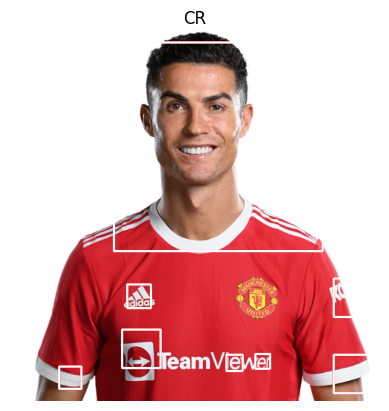

In [139]:
# print(scientists_resized.shape, half_window)
cf.show_images([render_boxex(scientists, face_positions_suppressed)], ["CR"])

## Testing RealTime (Using Video)

In [140]:
'''
vid = cv2.VideoCapture(0)

while(True):

    # Capture the video frame
    # by frame
    ret, frame = vid.read()


    # Display the resulting frame
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) /255
    gray_enhanced = (gamma(gray) *255).astype(np.uint8)
    img = imutils.resize(gray_enhanced ,width =450)
    scale_w= frame.shape[0] // img.shape[0]
    scale_h= frame.shape[1] // img.shape[1]
    positions = get_faces_in_multiple_scales(img,clf_test,4)
    positions =  non_maximum_supression_multiscale(positions, threshold=0.1)
    # print(positions)
    positions[:,0] *= scale_w 
    positions[:,1] *= scale_h
    positions[:,2] *= scale_w
    positions[:,3] *= scale_h 
    img = render_boxex(frame , positions)
    cv2.imshow('frame', img)
    io.imshow(img)
    # the 'q' button is set as the
    # quitting button you may use any
    # desired button of your choice
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# After the loop release the cap object
vid.release()
# Destroy all the windows
cv2.destroyAllWindows()
'''

"\nvid = cv2.VideoCapture(0)\n\nwhile(True):\n\n    # Capture the video frame\n    # by frame\n    ret, frame = vid.read()\n\n\n    # Display the resulting frame\n    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) /255\n    gray_enhanced = (gamma(gray) *255).astype(np.uint8)\n    img = imutils.resize(gray_enhanced ,width =450)\n    scale_w= frame.shape[0] // img.shape[0]\n    scale_h= frame.shape[1] // img.shape[1]\n    positions = get_faces_in_multiple_scales(img,clf_test,4)\n    positions =  non_maximum_supression_multiscale(positions, threshold=0.1)\n    # print(positions)\n    positions[:,0] *= scale_w \n    positions[:,1] *= scale_h\n    positions[:,2] *= scale_w\n    positions[:,3] *= scale_h \n    img = render_boxex(frame , positions)\n    cv2.imshow('frame', img)\n    io.imshow(img)\n    # the 'q' button is set as the\n    # quitting button you may use any\n    # desired button of your choice\n    if cv2.waitKey(1) & 0xFF == ord('q'):\n        break\n\n# After the loop release 